In [1]:
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

import pickle
from matplotlib import pyplot as plt

## 1. PGD

- 在Week5中，你已经完成了对LeNet5模型的FGSM攻击，请在此基础上实现多轮迭代的PGD攻击

- 具体实验步骤如下：
  1. 将代码文件上传到服务器端根目录，将week5保存的lenet5.pt迁移到/model路径下
     
  2. 在服务器端根目录下新建目录data，并将week6新版样本数据（Week567_img_label.pkl）上传至/data目录下
     
  3. 依照提示，完成Python文件中`pgd(imgs, epsilon, iter, model, criterion, labels)`函数的*TODO*内容
      - 完成模型的前向过程，根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取
  
      - 实现PGD对抗样本生成过程，在iter轮的优化过程中生成对抗扰动

      - 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）

      - **助教检查**时测试扰动大小$\epsilon=0.2$、攻击轮次$iter \in [5, 15, 30]$、单步步长$\alpha \in [0.03, 0.07, 0.15]$

      - **正确实现**要求**最佳攻击效果**的match rate $ < 0.2$
        - *注: 若尝试不同参数后，仍未达到验收目标，推荐设置LeNet5中卷积层的kernel_size=5
  4. 执行代码完成攻击与效果验证

In [2]:
from Week567_General_Code_Question import LeNet5, pgd, evaluate
from Week567_General_Code_Question import visualize_adv

### 目标模型加载

注意，请将week5保存的lenet5.pt迁移到/model路径下

In [3]:
model = LeNet5()
### 请将week5保存的lenet5.pt迁移到/model路径下
model.load_state_dict(torch.load('model/lenet5.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

C:\Users\w2213\AppData\Local\Temp\ipykernel_27660\4002751527.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/lenet5.pt'))


### 读入待攻击的样本
注意，需导入week6的新版本Week567_img_label.pkl

In [4]:
with open('data/Week567_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    imgs, labels = data['img'], data['label']

### 实现PGD生成对抗样本

依照提示，完成Python文件中`pgd(imgs, epsilon, iter, model, criterion, labels)`函数的*TODO*内容

- 完成模型的前向过程，根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取
  
- 实现PGD对抗样本生成过程，在iter轮的优化过程中生成对抗扰动

- 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）

- **助教检查**时测试扰动大小$\epsilon=0.2$、攻击轮次$iter \in [5, 15, 30]$、单步步长$\alpha \in [0.03, 0.07, 0.15]$

- **正确实现**要求**最佳攻击效果**的match rate $ < 0.2$

- 实现后评测对抗样本的攻击效果

下面是一些供你参考/可能用到的API函数：
- torch.Tensor.requires_grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)
  - 设置tensor是否加入计算图，即是否需要反向累积梯度
- torch.Tensor.grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)
  - 在loss.backward()后，获取tensor上的梯度
- torch.Tensor.sign() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.sign.html)
  - 取一个tensor中每个元素的符号（正负1），返回的形状与输入相同
- torch.clamp(*input*, *min=None*, *max=None*, ***, *out=None*) [Link](https://pytorch.org/docs/stable/generated/torch.clamp.html)
  - input: 需要clip的tensor
  - min, max: 截断的阈值，使tensor中在[min, max]以外的值被截断至min或max
- torch.Tensor.detach() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
  - 获取一个脱离计算图的tensor，获得的tensor不再会被反向计算梯度

In [5]:
epsilon = 0.2
iter = 5
alpha = 0.03
adv_xs = pgd(imgs, epsilon, alpha, iter, model, criterion, labels)
pred_label = evaluate(adv_xs, labels, model)

match rate: 0.1


### 可视化对抗样本与结果

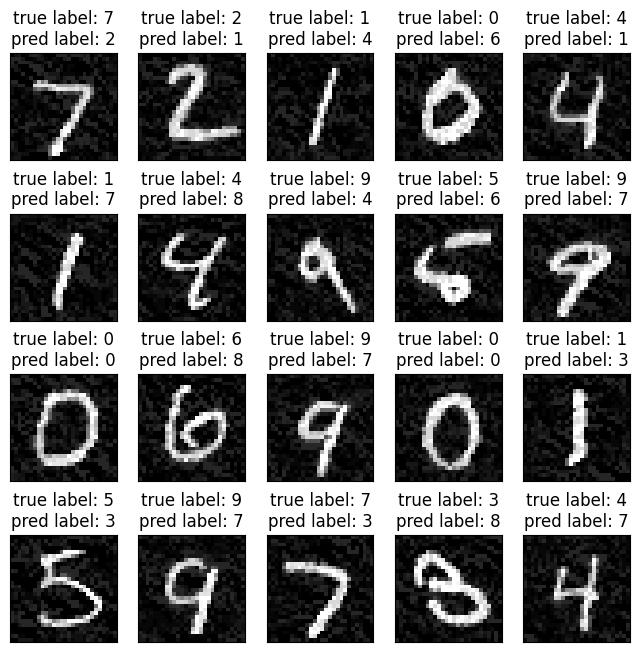

In [6]:
adv_imgs = adv_xs.reshape_as(imgs)
visualize_adv(adv_imgs, labels, pred_label)

### 保存生成的PGD对抗样本
- 请将week5保存的fgsm_img_label.pkl迁移到/data路径下
  
- 与week6保存的pgd_img_label.pkl进行对比（对抗样本与原图的l2距离）

In [7]:
with open('data/pgd_img_label.pkl', 'wb') as f:
    pickle.dump({
        'adv_img': adv_imgs,
        'true_label': labels,
        'pred_label': pred_label,
    }, f)

In [8]:
### 请将Week5保存的fgsm_img_label.pkl迁移到/data路径下
with open('data/fgsm_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    fgsm_imgs = data['adv_img']

In [9]:
# Compute perturbation from original img
delta_fgsm = fgsm_imgs - imgs
delta_pgd = adv_imgs - imgs

# Compute L2 distance
print(f'L2_FGSM: {delta_fgsm.pow(2).sum(dim=-1).sqrt().mean()}')
print(f'L2_PGD: {delta_pgd.pow(2).sum(dim=-1).sqrt().mean()}')

L2_FGSM: 0.7811228036880493
L2_PGD: 0.43034055829048157
